### Gerekli kütüphaneleri yükleme

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


### Veri setini yükleme

In [4]:
veri_seti = pd.read_csv('DepremSenaryosu.csv', sep=';')

### Veri setini gösterme

In [5]:
veri_seti.head()

,ilce_adi,mahalle_adi,mahalle_koy_uavt,cok_agir_hasarli_bina_sayisi,agir_hasarli_bina_sayisi,orta_hasarli_bina_sayisi,hafif_hasarli_bina_sayisi,can_kaybi_sayisi,agir_yarali_sayisi,hastanede_tedavi_sayisi,hafif_yarali_sayisi,dogalgaz_boru_hasari,icme_suyu_boru_hasari,atik_su_boru_hasari,gecici_barinma
0,ADALAR,BURGAZADA,40139,54,99,256,241,8,6,24,42,0,0,1,398
1,ADALAR,HEYBELİADA,40142,101,175,423,393,25,21,66,113,1,1,2,763
2,ADALAR,KINALIADA,40143,53,97,287,302,5,3,15,27,0,1,1,420
3,ADALAR,MADEN,40140,104,192,483,484,22,18,64,113,1,1,2,847
4,ADALAR,NİZAM,40141,101,180,445,422,16,13,48,83,1,2,2,687


### Kategorik sütunları sayısal değerlere dönüştürme

In [6]:
label_encoder = LabelEncoder()
veri_seti['ilce_adi'] = label_encoder.fit_transform(veri_seti['ilce_adi'])
veri_seti['mahalle_adi'] = label_encoder.fit_transform(veri_seti['mahalle_adi'])


### Giriş ve çıkış verilerini ayırma

In [7]:
X = veri_seti.drop(['agir_hasarli_bina_sayisi'], axis=1)
y = veri_seti['agir_hasarli_bina_sayisi']

### Eğitim ve test verilerine ayırma

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Kümeleme için KMeans modelini eğitme

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
veri_seti['Kume'] = kmeans.fit_predict(X)


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Test verilerine 'Kume' sütununu ekleme

In [10]:
X_test['Kume'] = kmeans.predict(X_test)

### Kümelere göre veriyi ayırma

In [11]:
kume1 = veri_seti[veri_seti['Kume'] == 0]
kume2 = veri_seti[veri_seti['Kume'] == 1]
kume3 = veri_seti[veri_seti['Kume'] == 2]

### Her küme için RandomForestRegressor modelini eğitme

In [12]:
model_kume1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_kume1.fit(kume1.drop(['agir_hasarli_bina_sayisi', 'Kume'], axis=1), kume1['agir_hasarli_bina_sayisi'])

model_kume2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_kume2.fit(kume2.drop(['agir_hasarli_bina_sayisi', 'Kume'], axis=1), kume2['agir_hasarli_bina_sayisi'])

model_kume3 = RandomForestRegressor(n_estimators=100, random_state=42)
model_kume3.fit(kume3.drop(['agir_hasarli_bina_sayisi', 'Kume'], axis=1), kume3['agir_hasarli_bina_sayisi'])


RandomForestRegressor(random_state=42)

### Test verilerini kümelere göre ayırma

In [13]:
X_test_kume1 = X_test[X_test['Kume'] == 0].drop(['Kume'], axis=1)
X_test_kume2 = X_test[X_test['Kume'] == 1].drop(['Kume'], axis=1)
X_test_kume3 = X_test[X_test['Kume'] == 2].drop(['Kume'], axis=1)

### Tahmin yapma

In [14]:
tahmin_kume1 = model_kume1.predict(X_test_kume1)
tahmin_kume2 = model_kume2.predict(X_test_kume2)
tahmin_kume3 = model_kume3.predict(X_test_kume3)

### Tahminleri birleştirme

In [15]:
tahminler = pd.concat([pd.Series(tahmin_kume1, index=X_test_kume1.index),
                      pd.Series(tahmin_kume2, index=X_test_kume2.index),
                      pd.Series(tahmin_kume3, index=X_test_kume3.index)])


### Gerçek ve tahmin edilen değerleri birleştirerek bir DataFrame oluşturma

In [16]:
tahmin_df = pd.DataFrame({'Gerçek': y_test, 'Tahmin': tahminler})

### İlk 10 gözlemi gösterme

In [17]:
print(tahmin_df.head(10))

    Gerçek  Tahmin
23       3    3.40
30       4    3.83
31       7    6.41
33       7    6.68
39       9    8.87
44      12   11.45
49      76   87.25
59       1    1.37
60     105  100.09
63     150  156.94


### Tahminler ile gerçek değerler arasındaki ilişkiyi gösteren bir grafik oluşturma

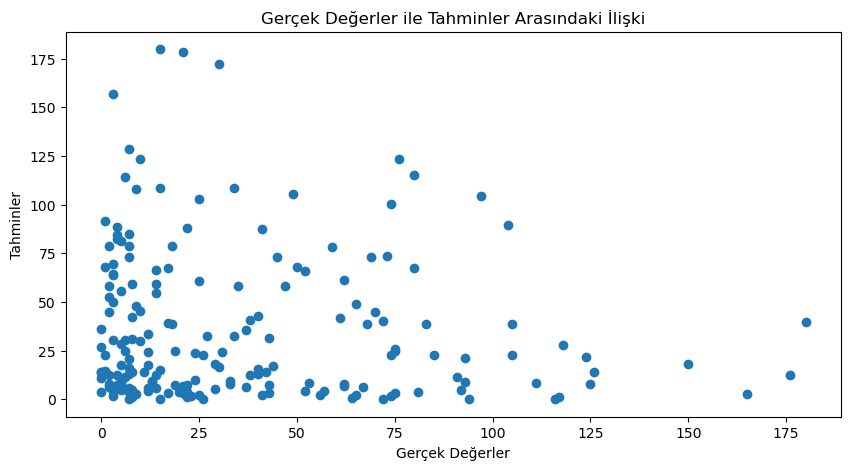

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, tahminler)
plt.title('Gerçek Değerler ile Tahminler Arasındaki İlişki')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.show()

### Performans metriklerini hesaplama

In [19]:
mae = mean_absolute_error(y_test, tahminler)
mse = mean_squared_error(y_test, tahminler)
rmse = np.sqrt(mse)

### Performans metriklerini yazdırma

In [20]:
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 39.89
MSE: 3099.43
RMSE: 55.67
